In [31]:
import scipy.io
import numpy as np
from random import shuffle
import scipy.ndimage
import os
import scipy.io as io
from PIL import Image

#from skimage import io

from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt
import numpy as np

In [32]:
def RobustPCA(X, lamba, mu, tol, max_iter):
    
    M,N=np.shape(X)
    unobserved=np.isnan(X)
    X[unobserved]=0
    normX= np.linalg.norm(X,'fro')
    
    #intial solution
    L = np.zeros((M, N))
    S = np.zeros((M, N))
    Y = np.zeros((M, N))

    for iter in range(max_iter):
    # ADMM step: update L and S
        
        L= Do(1/mu, X - S + (1/mu)*Y)
        S = So(lamb/mu, X - L + (1/mu)*Y)

        # and augmented lagrangian multiplier
        Z = X - L - S
        Z[unobserved] = 0 # skip missing values
        Y = Y + mu*Z

        err = np.linalg.norm(Z, 'fro') / normX
        outLine ="iter: %d\terr:%f\trank(L):%d\t" % (iter, err, matrix_rank(L))
        print(outLine)

        #if (i == 1) or (np.mod(i, 10) == 0) or (err < tol):
            #print('i: %04d\terr: %f\trank(L): %d\tcard(S): %d\n', i, err, rank(L), nnz(S(~unobserved)));
        if err<tol:
            break
            
    return L,S

        
def So(tau,X):
    # Shrinkage Operator
    r = np.sign(X)*np.maximum(abs(X) - tau, 0)
    return r

def Do(tau,X):
    # Shrinkage operator for singular values
    U, S, V = np.linalg.svd(X,full_matrices=False)
    
    k=np.diag(So(tau,S))
    a=np.dot(U,k)
    r=np.dot(a,V)
    
    return r

In [33]:
import time

def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    if tempBool:
        print( "Elapsed time: %f seconds.\n" %tempTimeInterval )

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [60]:
img=io.loadmat('moon.mat')['img']

msk=io.loadmat('msk.mat')['msk']


corrupted_img = img

In [61]:
np.shape(msk)
img_corrupted=corrupted_img
img_corrupted[msk > 0] = np.nan

In [41]:
img_corrupted=corrupted_img
img_corrupted[msk > 0] = np.nan

In [63]:
print('%d Corrupted Entries\n'% np.count_nonzero(np.isnan(img_corrupted)))

# constructing matrix X from overlapped patches

ws = 16 # window size
no_patches = int(np.shape(img)[0]/ws)
X = np.zeros((no_patches**2, ws**2))
k = 0
flag=0

1138 Corrupted Entries



In [64]:
for i in range(1,no_patches*2):
    for j in range(1,no_patches*2):
        
        r1_start=int(1+(i-1)*ws/2)-1
        r1_end=int((i+1)*ws/2)
        
        r2_start=int(1+(j-1)*ws/2)-1
        r2_end=int((j+1)*ws/2)
        
        patch=img_corrupted[r1_start:r1_end,r2_start:r2_end]
        
        if k<256:
            X[k,:] = patch.ravel()
        
        else:
            X = np.vstack([X, patch.ravel()])
            
        k = k + 1

In [65]:
# Default function values

max_iter=1000
#lamb = 1 / np.sqrt(max(M,N))
lamb=0.02
mu = 1.0
tol = 1e-5

In [66]:
# apply Robust PCA
tic()
[L, S] = RobustPCA(X, lamb, mu, tol,max_iter)
toc()

iter: 0	err:0.019728	rank(L):116	
iter: 1	err:0.008088	rank(L):109	
iter: 2	err:0.006359	rank(L):85	
iter: 3	err:0.005519	rank(L):64	
iter: 4	err:0.004873	rank(L):50	
iter: 5	err:0.004357	rank(L):40	
iter: 6	err:0.003904	rank(L):34	
iter: 7	err:0.003513	rank(L):28	
iter: 8	err:0.003162	rank(L):26	
iter: 9	err:0.002855	rank(L):24	
iter: 10	err:0.002569	rank(L):23	
iter: 11	err:0.002327	rank(L):23	
iter: 12	err:0.002134	rank(L):23	
iter: 13	err:0.001959	rank(L):24	
iter: 14	err:0.001824	rank(L):24	
iter: 15	err:0.001745	rank(L):25	
iter: 16	err:0.001676	rank(L):25	
iter: 17	err:0.001603	rank(L):25	
iter: 18	err:0.001532	rank(L):25	
iter: 19	err:0.001465	rank(L):25	
iter: 20	err:0.001383	rank(L):25	
iter: 21	err:0.001282	rank(L):25	
iter: 22	err:0.001193	rank(L):25	
iter: 23	err:0.001072	rank(L):26	
iter: 24	err:0.000978	rank(L):26	
iter: 25	err:0.000897	rank(L):26	
iter: 26	err:0.000815	rank(L):26	
iter: 27	err:0.000748	rank(L):26	
iter: 28	err:0.000682	rank(L):27	
iter: 29	err:0.000628	

In [67]:
img_reconstructed = np.zeros(np.shape(img))
img_noise = np.zeros(np.shape(img))

In [68]:
k = 0;
for i in range(1,no_patches*2):
    for j in range(1,no_patches*2):
        
        # averaging the overlapped patches to retreieve image data from L and S
        # fewer than four patches averaged
        
        patch = np.reshape(L[k,:],(ws,ws))
        
        r1_start=int(1+(i-1)*ws/2)-1
        r1_end=int((i+1)*ws/2)
        
        r2_start=int(1+(j-1)*ws/2)-1
        r2_end=int((j+1)*ws/2)
        
        img_reconstructed[r1_start:r1_end,r2_start:r2_end] = img_reconstructed[r1_start:r1_end,r2_start:r2_end] + 0.25*patch
        
        
        patch = np.reshape(S[k,:],(ws,ws))
        img_noise[r1_start:r1_end,r2_start:r2_end] = img_noise[r1_start:r1_end,r2_start:r2_end] + 0.25*patch
        
        k = k + 1

img_final = img_reconstructed
img_final[~np.isnan(img_corrupted)] = img_corrupted[~np.isnan(img_corrupted)]

In [69]:
np.shape(img_reconstructed)

(256, 256)

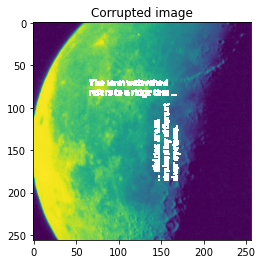

In [70]:
plt.imshow(img_corrupted)
plt.title('Corrupted image')
plt.savefig('Corrupted image.png')

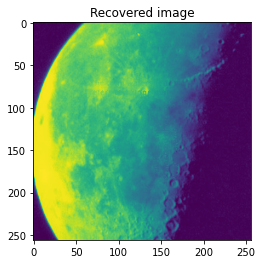

In [71]:
plt.imshow(img_final)
plt.title('Recovered image')
plt.savefig('Recovered image.png')

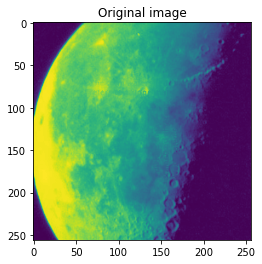

In [72]:
plt.imshow(img_final)
plt.title('Original image')
plt.savefig('Original image.png')

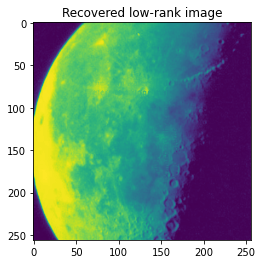

In [73]:
plt.imshow(img_reconstructed)
plt.title('Recovered low-rank image')
plt.savefig('Recovered low-rank image.png')

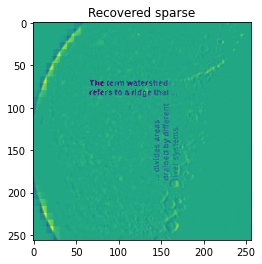

In [74]:
plt.imshow(img_noise)
plt.title('Recovered sparse')
plt.savefig('Recovered sparse image.png')